In [1]:
import numpy as np 
import pandas as pd
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score
from collections import Counter
import re
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from torch.utils.data import DataLoader
from transformers import get_scheduler
from sklearn.metrics import f1_score
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm  

2025-05-18 23:54:46.652488: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747612486.864143      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747612486.924314      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
from collections import Counter, defaultdict
import math
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from gensim.models import Word2Vec
from collections import Counter

In [7]:

df = pd.read_csv("/kaggle/input/dl-2025-study-competition-2/train.csv")


texts = df['text'].values

df['label_list'] = df['labels'].apply(lambda x: list(map(int, x.strip().split())))

## Анализ данных

In [37]:
number_of_classes = len(df['label_list'][0])
number_of_classes

20

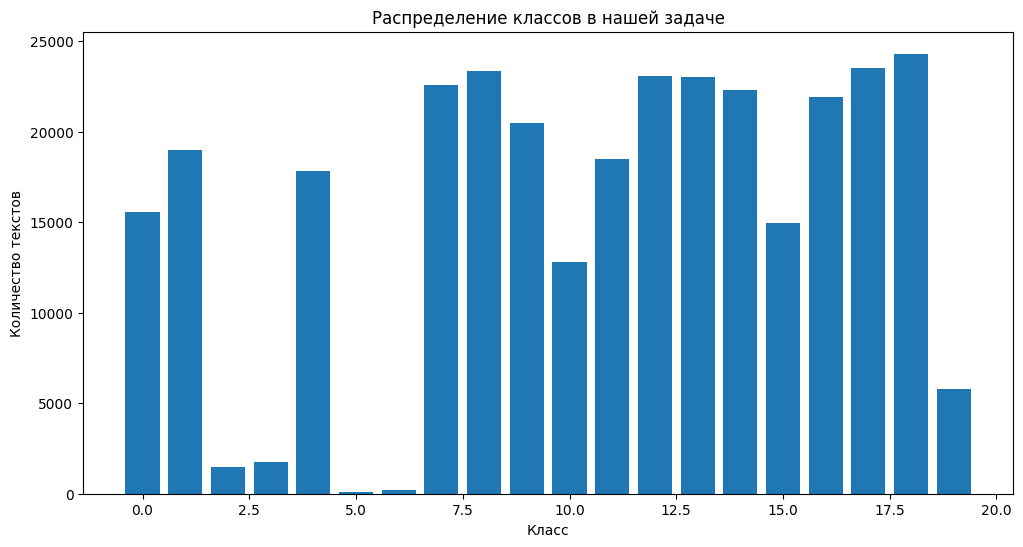

In [38]:
matrix_of_labels = np.array(df['label_list'].tolist())
class_counts = matrix_of_labels.sum(axis=0)

plt.figure(figsize=(12, 6))
plt.bar(range(number_of_classes), class_counts)
plt.xlabel("Класс")
plt.ylabel("Количество текстов")
plt.title("Распределение классов в нашей задаче")
plt.show()

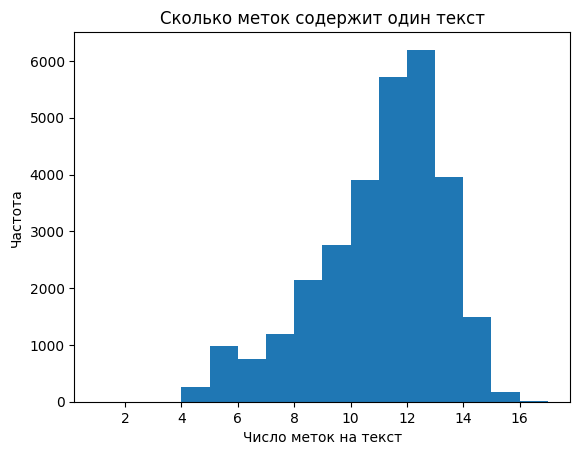

In [39]:
number_of_labels = matrix_of_labels.sum(axis=1)

plt.hist(number_of_labels, bins=range(1, number_of_labels.max()+2))
plt.xlabel("Число меток на текст")
plt.ylabel("Частота")
plt.title("Сколько меток содержит один текст")
plt.show()

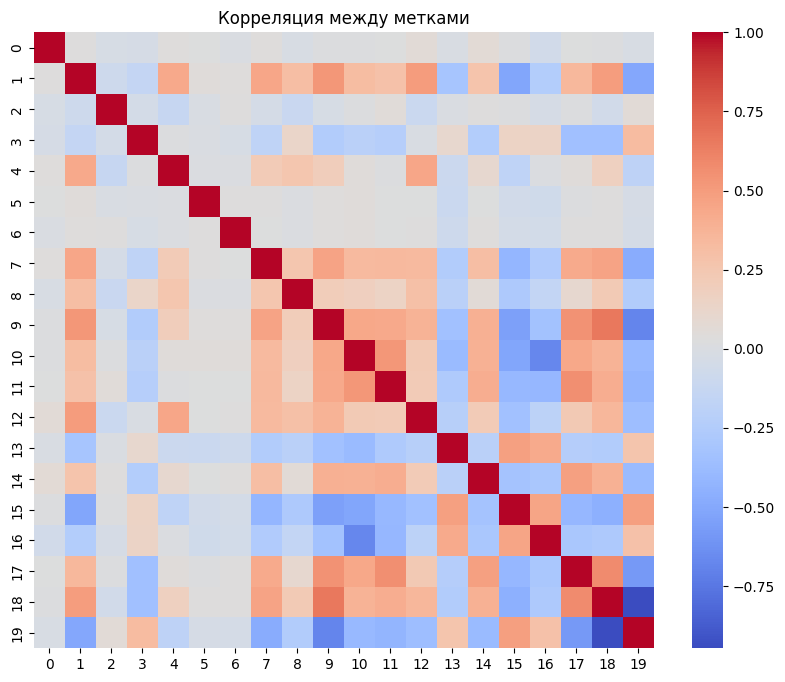

In [40]:
corr = np.corrcoef(matrix_of_labels.T)

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.title("Корреляция между метками")
plt.show()

In [41]:
def get_examples_for_class(df, label_matrix, class_idx, num_samples=2):

    class_texts = df[label_matrix[:, class_idx] == 1]['text'].head(num_samples)
    
    for idx, text in enumerate(class_texts):
        print(f"\nПример {idx + 1} для класса {class_idx}:\n{text}")


for i in range (2):
    get_examples_for_class(df, matrix_of_labels, i)


Пример 1 для класса 0:
15 января
Детская развлекательная программа
15-00 бесплатно
❗️
@
cafeotdyh
Кафе "Отдых"
📍
Запись обязательно +73472228532

Пример 2 для класса 0:
Впервые в Уфе танцевальная терапия в группе с практикующим психологом
Тема встречи: «Отношения. Доверие. Контакт»
Приходите, если:
🔸
вы хотите наладить или поисследовать свои отношения с
-  телом
- собой
- близким человеком
- работой
- деньгами
🔸
не можете разрешить или забыть какую-то  ситуацию, связанную с отношениями
🔸
не умеете доверять или делегировать
🔸
тяжело вступаете в контакт
Задать вопрос психологу курса
и записаться можно здесь:
@LeontevaKsenia
Дата
: 26 января
Время
: 19.00-21.00
Адрес
: Коммунистическая, 45/3, Б/ц "Деловой двор"
Стоимость: 1500
Что нужно для занятия:
удобная одежда, носки, вода, желание танцевать.

Пример 1 для класса 1:
Впервые в Уфе танцевальная терапия в группе с практикующим психологом
Тема встречи: «Отношения. Доверие. Контакт»
Приходите, если:
🔸
вы хотите наладить или поисследовать 

Видим, что есть дисбаланс классов. Также есть шумные факторы, такие как url сайтов, телефоны, упоминания людей ников и пр. Их можно после почистить. Мы также видим, что например в нулевом классе речь про досуг, общение, психологию и пр, первый например выглядит как искусство и связанные с ним мероприятия.


Анализ чисток для текста

In [6]:
def clean_text(text):
    text = re.sub(r"http\S+|www\.\S+", "", text)
    text = re.sub(r"\+?\d[\d\s\-]{6,}", "", text)
    text = re.sub(r"@\w+", "", text)
    return text



#Функция для чистки для модели Берт
def bert(text):
    text = clean_text(text)
    text = text.strip()
    return text


#Функция для модели tf-idf
def ti(text):
    text = clean_text(text)
    return text.strip()


#Функция для модели  w2v 
def w2(text):
    text = clean_text(text)
    text = text.strip().lower()
    return text


df["cleaned_text"] = df["text"].apply(w2)
cleaned_text = df["cleaned_text"].tolist()
labels = df["label_list"].tolist()

def cnn(text):
    text = clean_text(text)
    return text.lower()

# Код для модели Берт 

In [5]:
X_train, X_val, y_train, y_val = train_test_split(
    cleaned_text, labels, test_size=0.2)
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

class EventDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoded = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        input_ids = encoded["input_ids"].squeeze()
        attention_mask = encoded["attention_mask"].squeeze()
        label_tensor = torch.FloatTensor(self.labels[idx])
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": label_tensor
        }

train_dataset = EventDataset(X_train, y_train, tokenizer)
val_dataset = EventDataset(X_val, y_val, tokenizer)
from transformers import BertForSequenceClassification

num_classes = len(y_train[0])
model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased",
    num_labels=num_classes,
    problem_type="multi_label_classification"
)


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
num_epochs = 2
total_steps = len(train_loader) * num_epochs
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=100, num_training_steps=total_steps)

best_val_f1 = 0
patience = 2
patience_counter = 0

train_losses, val_losses = [], []
val_f1s = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1} Train", leave=False)
    for batch in train_bar:
        optimizer.zero_grad()
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        running_loss += loss.item()

        train_bar.set_postfix(loss=loss.item())

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    val_loss = 0
    all_preds = []
    all_labels = []

  
    val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1} Val", leave=False)
    with torch.no_grad():
        for batch in val_bar:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            val_loss += loss.item()

            logits = outputs.logits
            probs = torch.sigmoid(logits).cpu().numpy()
            preds = (probs > 0.5).astype(int)

            all_preds.extend(preds)
            all_labels.extend(batch["labels"].cpu().numpy())

            val_bar.set_postfix(loss=loss.item())

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    f1 = f1_score(all_labels, all_preds, average="macro")
    val_f1s.append(f1)

    print(f"[{epoch+1}] Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val F1: {f1:.4f}")

    if f1 > best_val_f1:
        best_val_f1 = f1
        torch.save(model.state_dict(), "best_model.pt")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping")
            break


[1] Train Loss: 0.2487 | Val Loss: 0.1856 | Val F1: 0.7790


[2] Train Loss: 0.1617 | Val Loss: 0.1542 | Val F1: 0.7996


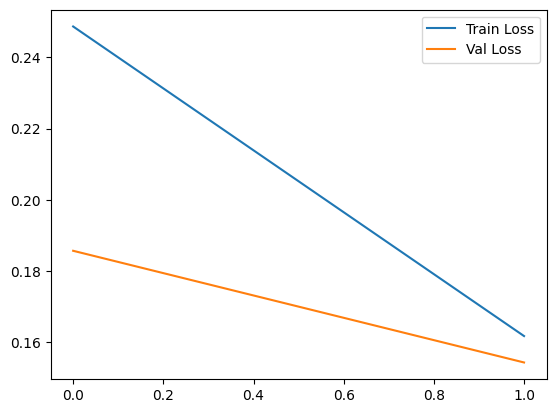

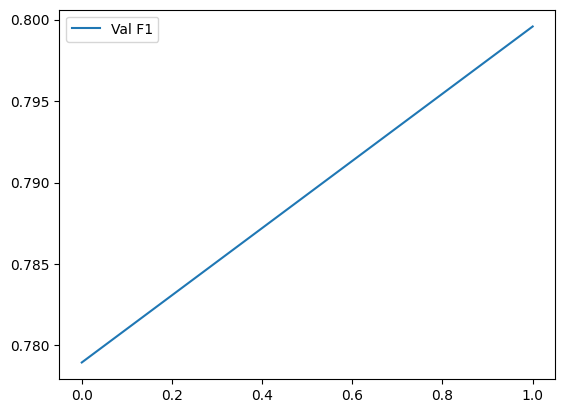

In [9]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.show()
plt.plot(val_f1s, label="Val F1")
plt.legend()
plt.show()

Я начинала с берт и именно он выдал результат 0.84 на 10 эпохах(повезло повезло). Остальные модели в основном не доходили до такой отметки, и останавливались на 0.8-0.83

# Код для tf_idf

In [10]:
def build_vocab(texts, max_features=5000):
    word_freq = Counter()
    for text in texts:
        word_freq.update(text.lower().split())

    most_common = word_freq.most_common(max_features)
    vocab = {word: idx for idx, (word, _) in enumerate(most_common)}
    return vocab

def compute_idf(texts, vocab):
    N = len(texts)
    idf = defaultdict(lambda: 0)

    for text in texts:
        words = set(text.lower().split())
        for word in words:
            if word in vocab:
                idf[word] += 1

    for word in vocab:
        df = idf[word]
        idf[word] = math.log((N + 1) / (df + 1)) + 1  # сглажённый IDF
    return idf

def compute_tfidf_matrix(texts, vocab, idf):
    tfidf_matrix = np.zeros((len(texts), len(vocab)), dtype=np.float32)
    for i, text in enumerate(texts):
        word_counts = Counter(text.lower().split())
        total_words = sum(word_counts.values())
        for word, count in word_counts.items():
            if word in vocab:
                tf = count / total_words
                tfidf_matrix[i, vocab[word]] = tf * idf[word]
    return tfidf_matrix

X_train, X_val, y_train, y_val = train_test_split(
    cleaned_text, labels, test_size=0.2)

vocab = build_vocab(X_train, max_features=5000)
idf = compute_idf(X_train, vocab)

X_train = compute_tfidf_matrix(X_train, vocab, idf)
X_val = compute_tfidf_matrix(X_val, vocab, idf)

y_train = np.array(y_train, dtype=np.float32)
y_val = np.array(y_val, dtype=np.float32)


class SimpleMLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),

            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        return self.model(x)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")





train_ds = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
val_ds = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)


model = SimpleMLP(input_dim=X_train.shape[1], output_dim=y_train.shape[1]).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()


Epoch 1 - Train: 100%|██████████| 370/370 [00:02<00:00, 158.31it/s]


Epoch 1 | Train Loss: 0.4080 | Val Loss: 0.2797 | Val F1: 0.7485


Epoch 2 - Train: 100%|██████████| 370/370 [00:01<00:00, 203.77it/s]


Epoch 2 | Train Loss: 0.2461 | Val Loss: 0.2254 | Val F1: 0.7631


Epoch 3 - Train: 100%|██████████| 370/370 [00:01<00:00, 202.00it/s]


Epoch 3 | Train Loss: 0.1977 | Val Loss: 0.2043 | Val F1: 0.7717


Epoch 4 - Train: 100%|██████████| 370/370 [00:01<00:00, 201.27it/s]


Epoch 4 | Train Loss: 0.1667 | Val Loss: 0.1956 | Val F1: 0.7814


Epoch 5 - Train: 100%|██████████| 370/370 [00:01<00:00, 197.70it/s]


Epoch 5 | Train Loss: 0.1451 | Val Loss: 0.1905 | Val F1: 0.7921


Epoch 6 - Train: 100%|██████████| 370/370 [00:01<00:00, 200.53it/s]


Epoch 6 | Train Loss: 0.1283 | Val Loss: 0.1922 | Val F1: 0.7961


Epoch 7 - Train: 100%|██████████| 370/370 [00:01<00:00, 201.49it/s]


Epoch 7 | Train Loss: 0.1143 | Val Loss: 0.1883 | Val F1: 0.8012


Epoch 8 - Train: 100%|██████████| 370/370 [00:01<00:00, 190.85it/s]


Epoch 8 | Train Loss: 0.1032 | Val Loss: 0.1921 | Val F1: 0.8033


Epoch 9 - Train: 100%|██████████| 370/370 [00:01<00:00, 198.51it/s]


Epoch 9 | Train Loss: 0.0936 | Val Loss: 0.1981 | Val F1: 0.8196


Epoch 10 - Train: 100%|██████████| 370/370 [00:01<00:00, 201.48it/s]


Epoch 10 | Train Loss: 0.0851 | Val Loss: 0.1993 | Val F1: 0.8210


Epoch 11 - Train: 100%|██████████| 370/370 [00:01<00:00, 200.12it/s]


Epoch 11 | Train Loss: 0.0787 | Val Loss: 0.2078 | Val F1: 0.8217


Epoch 12 - Train: 100%|██████████| 370/370 [00:01<00:00, 199.42it/s]


Epoch 12 | Train Loss: 0.0734 | Val Loss: 0.2073 | Val F1: 0.8210


Epoch 13 - Train: 100%|██████████| 370/370 [00:01<00:00, 203.01it/s]


Epoch 13 | Train Loss: 0.0680 | Val Loss: 0.2093 | Val F1: 0.8275


Epoch 14 - Train: 100%|██████████| 370/370 [00:01<00:00, 197.63it/s]


Epoch 14 | Train Loss: 0.0647 | Val Loss: 0.2158 | Val F1: 0.8271


Epoch 15 - Train: 100%|██████████| 370/370 [00:01<00:00, 199.40it/s]


Epoch 15 | Train Loss: 0.0605 | Val Loss: 0.2196 | Val F1: 0.8284


Epoch 16 - Train: 100%|██████████| 370/370 [00:01<00:00, 201.32it/s]


Epoch 16 | Train Loss: 0.0576 | Val Loss: 0.2231 | Val F1: 0.8285


Epoch 17 - Train: 100%|██████████| 370/370 [00:01<00:00, 199.10it/s]


Epoch 17 | Train Loss: 0.0547 | Val Loss: 0.2226 | Val F1: 0.8291


Epoch 18 - Train: 100%|██████████| 370/370 [00:01<00:00, 199.57it/s]


Epoch 18 | Train Loss: 0.0526 | Val Loss: 0.2273 | Val F1: 0.8381


Epoch 19 - Train: 100%|██████████| 370/370 [00:01<00:00, 200.79it/s]


Epoch 19 | Train Loss: 0.0505 | Val Loss: 0.2322 | Val F1: 0.8383


Epoch 20 - Train: 100%|██████████| 370/370 [00:01<00:00, 202.37it/s]


Epoch 20 | Train Loss: 0.0483 | Val Loss: 0.2390 | Val F1: 0.8371


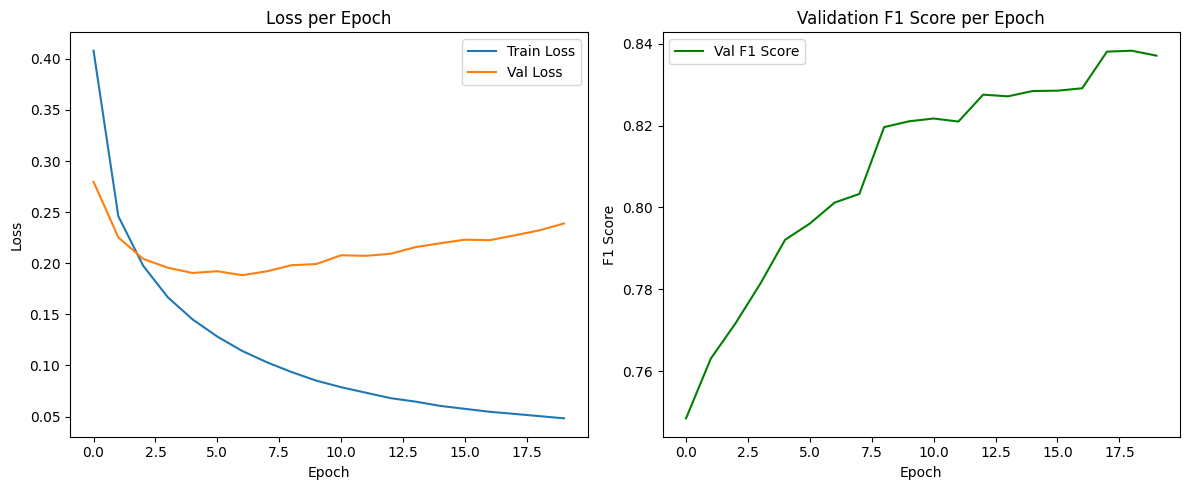

In [11]:
best_f1 = 0
patience = 2
patience_counter = 0

train_losses = []
val_losses = []
val_f1s = []

for epoch in range(20):
    model.train()
    train_loss = 0
    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch+1} - Train"):
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    all_preds, all_targets = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            val_loss += loss.item()

            preds = torch.sigmoid(logits).cpu().numpy() > 0.5
            all_preds.extend(preds)
            all_targets.extend(yb.cpu().numpy())

    val_f1 = f1_score(all_targets, all_preds, average="macro")
    train_losses.append(train_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    val_f1s.append(val_f1)

    print(f"Epoch {epoch+1} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | Val F1: {val_f1:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        patience_counter = 0
        torch.save(model.state_dict(), "best_tfidf_model.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping.")
            break

# Отрисовка графиков после завершения обучения
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_f1s, label="Val F1 Score", color='green')
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Validation F1 Score per Epoch")
plt.legend()

plt.tight_layout()
plt.show()


# код для модели w2v

In [12]:
tokenized = [t.split() for t in cleaned_text]
w2v_model = Word2Vec(sentences=tokenized, vector_size=300, window=5, min_count=2, workers=4, sg=1)


def get_mean_vector(tokens, model, dim=300):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if not vectors:
        return np.zeros(dim)
    return np.mean(vectors, axis=0)

X = np.array([get_mean_vector(t.split(), w2v_model) for t in cleaned_text])
y = np.array(labels)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

class W2VDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = W2VDataset(X_train, y_train)
val_dataset = W2VDataset(X_val, y_val)

class Word2VecDeepMLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.net(x)


Epoch 1: Train Loss = 0.3462, Val Loss = 0.2607, F1 = 0.7333
Лучшая модель сохранена
Epoch 2: Train Loss = 0.2831, Val Loss = 0.2580, F1 = 0.7381
Лучшая модель сохранена
Epoch 3: Train Loss = 0.2740, Val Loss = 0.2417, F1 = 0.7510
Лучшая модель сохранена
Epoch 4: Train Loss = 0.2639, Val Loss = 0.2310, F1 = 0.7548
Лучшая модель сохранена
Epoch 5: Train Loss = 0.2579, Val Loss = 0.2315, F1 = 0.7559
Лучшая модель сохранена
Epoch 6: Train Loss = 0.2528, Val Loss = 0.2269, F1 = 0.7580
Лучшая модель сохранена
Epoch 7: Train Loss = 0.2479, Val Loss = 0.2198, F1 = 0.7689
Лучшая модель сохранена
Epoch 8: Train Loss = 0.2441, Val Loss = 0.2235, F1 = 0.7706
Лучшая модель сохранена
Epoch 9: Train Loss = 0.2414, Val Loss = 0.2189, F1 = 0.7710
Лучшая модель сохранена
Epoch 10: Train Loss = 0.2386, Val Loss = 0.2213, F1 = 0.7877
Лучшая модель сохранена
Epoch 11: Train Loss = 0.2366, Val Loss = 0.2156, F1 = 0.7816
Epoch 12: Train Loss = 0.2339, Val Loss = 0.2132, F1 = 0.7917
Лучшая модель сохранена
E

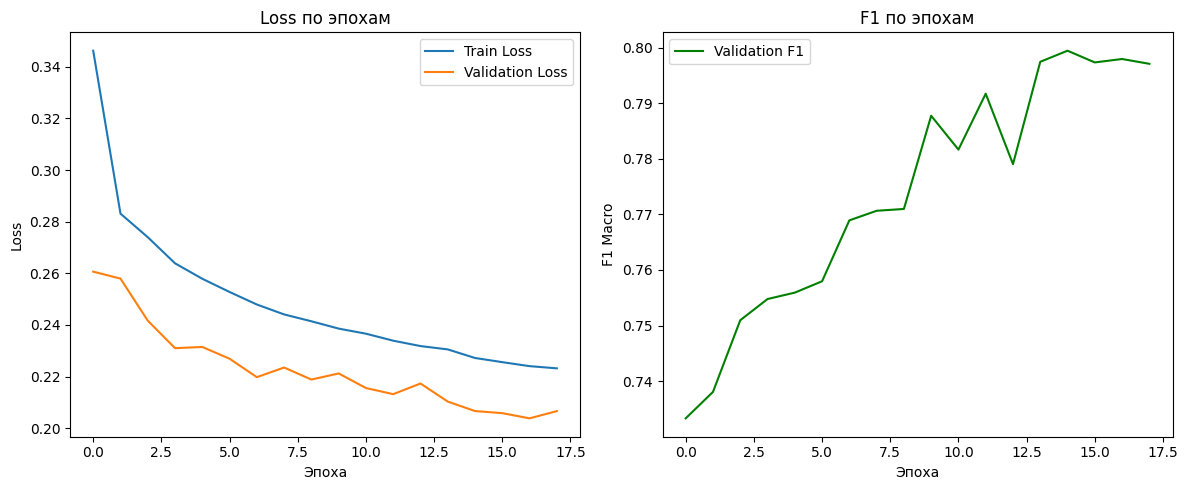

In [16]:
EPOCHS = 25
PATIENCE = 3
WARMUP_EPOCHS = 3
LR = 1e-3
from torch.optim.lr_scheduler import LambdaLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = Word2VecDeepMLP(300, y.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.BCEWithLogitsLoss()


def lr_lambda(epoch):
    if epoch < WARMUP_EPOCHS:
        return float(epoch + 1) / WARMUP_EPOCHS
    return 1.0

scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


train_loss_history = []
val_loss_history = []
val_f1_history = []

best_f1 = 0
stagnation = 0

# Цикл обучения
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        logits = model(X_batch)
        loss = loss_fn(logits, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)

    scheduler.step()

    # Валидация
    model.eval()
    val_loss = 0
    preds = []
    true = []

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            logits = model(X_batch)
            loss = loss_fn(logits, y_batch)
            val_loss += loss.item()

            probs = torch.sigmoid(logits).cpu().numpy()
            preds.extend((probs > 0.5).astype(int))
            true.extend(y_batch.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_loss_history.append(avg_val_loss)

    f1 = f1_score(true, preds, average="macro")
    val_f1_history.append(f1)

    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}, F1 = {f1:.4f}")

    # Сохранение лучшей модели и ранняя остановка
    if f1 > best_f1:
        best_f1 = f1
        stagnation = 0
        torch.save(model.state_dict(), "best_model.pt")
        print("Лучшая модель сохранена")
    else:
        stagnation += 1
        if stagnation >= PATIENCE:
            print(" Ранняя остановка")
            break

# Визуализация
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.title("Loss по эпохам")
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_f1_history, color='green', label="Validation F1")
plt.title("F1 по эпохам")
plt.xlabel("Эпоха")
plt.ylabel("F1 Macro")
plt.legend()

plt.tight_layout()
plt.savefig("training_curves.png")
plt.show()

# Код для модели встроенный эмбеддинг в нейросетевое решение на свёрточных сетях

In [20]:
df = pd.read_csv("/kaggle/input/dl-2025-study-competition-2/train.csv")
df['label_list'] = df['labels'].apply(lambda x: list(map(int, x.strip().split())))


def cnn(text):
    text = clean_text(text)
    return text.lower()

df["cleaned_text"] = df["text"].apply(cnn)
texts = df["cleaned_text"].tolist()
labels = df["label_list"].tolist()


def tokenize(text):
    return text.split()


all_tokens = [token for text in texts for token in tokenize(text)]
counter = Counter(all_tokens)
min_freq = 2 


PAD_TOKEN = "<pad>"
UNK_TOKEN = "<unk>"

vocab = {PAD_TOKEN:0, UNK_TOKEN:1}
for word, freq in counter.items():
    if freq >= min_freq:
        vocab[word] = len(vocab)


def encode_text(text):
    return [vocab.get(token, vocab[UNK_TOKEN]) for token in tokenize(text)]


MAX_LEN = 128
def pad_sequence(seq):
    return seq[:MAX_LEN] + [vocab[PAD_TOKEN]] * max(0, MAX_LEN - len(seq))


class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.inputs = [pad_sequence(encode_text(text)) for text in texts]
        self.labels = labels

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return {
            "input_ids": torch.tensor(self.inputs[idx], dtype=torch.long),
            "labels": torch.tensor(self.labels[idx], dtype=torch.float)
        }


X_train, X_val, y_train, y_val = train_test_split(texts, labels, test_size=0.2, random_state=42)

train_dataset = TextDataset(X_train, y_train)
val_dataset = TextDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


class TextCNN(nn.Module):
    def __init__(self, embed_dim, num_classes):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=embed_dim, out_channels=128, kernel_size=5)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):  # x — это [B, T, E]
        x = x.transpose(1, 2)                   # [B, E, T] — Conv1d ожидает channels=E
        x = F.relu(self.conv1(x))              # [B, 128, T']
        x = F.max_pool1d(x, kernel_size=x.size(2)).squeeze(2)  # [B, 128]
        x = self.dropout(x)
        return self.fc(x)      
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNNClassifier(
    vocab_size=len(vocab),
    embed_dim=128,
    num_classes=len(labels[0]),
    pad_idx=vocab[PAD_TOKEN]
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()


for epoch in range(10):
    model.train()
    train_loss = 0
    for batch in train_loader:
        inputs = batch["input_ids"].to(device)
        targets = batch["labels"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_preds, val_targets = [], []
    with torch.no_grad():
        for batch in val_loader:
            inputs = batch["input_ids"].to(device)
            targets = batch["labels"].to(device)
            outputs = model(inputs)
            preds = (torch.sigmoid(outputs) > 0.5).int().cpu().numpy()
            val_preds.extend(preds)
            val_targets.extend(targets.cpu().numpy())

    f1 = f1_score(val_targets, val_preds, average="macro")
    print(f"[{epoch+1}] Train loss: {train_loss/len(train_loader):.4f} | Val F1: {f1:.4f}")


[1] Train loss: 0.3667 | Val F1: 0.7253
[2] Train loss: 0.2869 | Val F1: 0.7374
[3] Train loss: 0.2570 | Val F1: 0.7621
[4] Train loss: 0.2342 | Val F1: 0.7689
[5] Train loss: 0.2151 | Val F1: 0.7721
[6] Train loss: 0.1977 | Val F1: 0.7730
[7] Train loss: 0.1823 | Val F1: 0.7775
[8] Train loss: 0.1670 | Val F1: 0.7771
[9] Train loss: 0.1536 | Val F1: 0.7870
[10] Train loss: 0.1413 | Val F1: 0.7910


# код для встроенный эмбеддинг в нейросетевое решение на рекуррентных сетях

In [24]:

MAX_LEN = 100
BATCH_SIZE = 32
EPOCHS = 20
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
PATIENCE = 3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def build_vocab(texts, min_freq=1):
    counter = Counter()
    for text in texts:
        counter.update(text.split())
    vocab = {"<pad>": 0, "<unk>": 1}
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = len(vocab)
    return vocab

vocab = build_vocab(cleaned_text)
pad_idx = vocab["<pad>"]


def text_to_indices(text, vocab, max_len=MAX_LEN):
    tokens = text.split()[:max_len]
    indices = [vocab.get(token, vocab["<unk>"]) for token in tokens]
    return torch.tensor(indices, dtype=torch.long)

text_indices = [text_to_indices(text, vocab) for text in cleaned_text]
padded_texts = pad_sequence(text_indices, batch_first=True, padding_value=pad_idx)


num_classes = max(max(lbl) for lbl in labels) + 1
targets = torch.zeros((len(labels), num_classes))
for i, lbl in enumerate(labels):
    targets[i, lbl] = 1


class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

x_train, x_val, y_train, y_val = train_test_split(
    padded_texts, targets, test_size=0.2
)

train_data = TextDataset(x_train, y_train)
val_data = TextDataset(x_val, y_val)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)

# 6. Модель LSTM
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim, out_dim, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(emb_dim, hid_dim, batch_first=True)
        self.linear = nn.Linear(hid_dim, out_dim)

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        return self.linear(hidden[-1])

# 7. Инициализация модели
model = LSTMClassifier(
    vocab_size=len(vocab),
    emb_dim=EMBEDDING_DIM,
    hid_dim=HIDDEN_DIM,
    out_dim=num_classes,
    pad_idx=pad_idx
).to(DEVICE)


Эпоха 1 — обучение: 100%|██████████| 740/740 [00:02<00:00, 265.60it/s]


[Эпоха 1] Train Loss: 0.7016 | Val Loss: 0.7017 | Val F1: 0.5211
Лучшая модель сохранена


Эпоха 2 — обучение: 100%|██████████| 740/740 [00:02<00:00, 276.71it/s]


[Эпоха 2] Train Loss: 0.7016 | Val Loss: 0.7017 | Val F1: 0.5211


Эпоха 3 — обучение: 100%|██████████| 740/740 [00:02<00:00, 276.07it/s]


[Эпоха 3] Train Loss: 0.7016 | Val Loss: 0.7017 | Val F1: 0.5211
Ранняя остановка


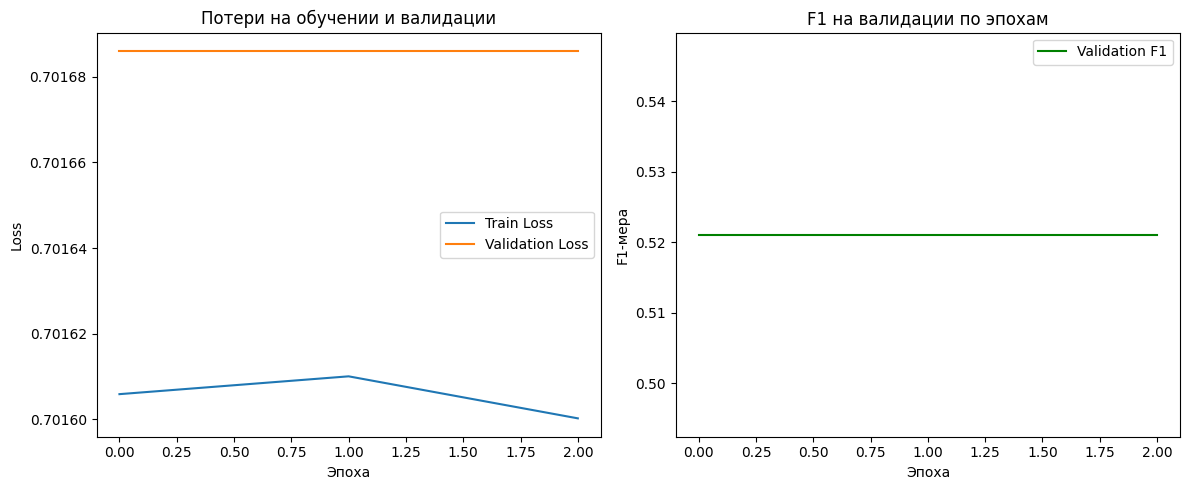

In [26]:
train_loss_history = []
val_loss_history = []
val_f1_history = []

best_f1 = 0
stagnation = 0 
early_stop_patience = 2

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0

    for x_batch, y_batch in tqdm(train_loader, desc=f"Эпоха {epoch + 1} — обучение"):
        x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)

  
    model.eval()
    val_loss = 0
    preds_all, targets_all = [], []

    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

            preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy()
            targets = y_batch.cpu().numpy()

            preds_all.extend(preds)
            targets_all.extend(targets)

    avg_val_loss = val_loss / len(val_loader)
    val_loss_history.append(avg_val_loss)

    f1 = f1_score(targets_all, preds_all, average="macro")
    val_f1_history.append(f1)

    print(f"[Эпоха {epoch + 1}] Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val F1: {f1:.4f}")

    
    if f1 > best_f1:
        best_f1 = f1
        stagnation = 0
        torch.save(model.state_dict(), "best_model.pt")
        print("Лучшая модель сохранена")
    else:
        stagnation += 1
        if stagnation >= early_stop_patience:
            print("Ранняя остановка")
            break


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.title("Потери на обучении и валидации")
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_f1_history, color='green', label="Validation F1")
plt.title("F1 на валидации по эпохам")
plt.xlabel("Эпоха")
plt.ylabel("F1-мера")
plt.legend()

plt.tight_layout()
plt.savefig("loss_f1_curves.png")
plt.show()


# генерация

In [27]:
from collections import Counter
import random
import pandas as pd

from transformers import T5ForConditionalGeneration, T5Tokenizer

decoder_model_name = "t5-small"  
tokenizer = T5Tokenizer.from_pretrained(decoder_model_name)
decoder = T5ForConditionalGeneration.from_pretrained(decoder_model_name).to(DEVICE)


combo_counts = Counter(tuple(sorted(lbls)) for lbls in labels)
unique_combinations = list(combo_counts.keys())
total_count = sum(combo_counts.values())
combo_probabilities = [combo_counts[combo] / total_count for combo in unique_combinations]

new_label_combinations = random.choices(unique_combinations, weights=combo_probabilities, k=1000)


def generate_text_by_labels(label_list):
    
    label_str = " ".join(str(l) for l in label_list)
    prompt = f"генерация меток: {label_str}"
    inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)
    outputs = decoder.generate(
        **inputs,
        max_length=MAX_LEN,
        num_beams=5,
        no_repeat_ngram_size=2,
        early_stopping=True
    )
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return generated_text


synthetic_texts = [generate_text_by_labels(list(lbls)) for lbls in new_label_combinations]




tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

NameError: name 'clean_text_fn' is not defined

In [32]:
synthetic_df = pd.DataFrame({
    "text": synthetic_texts,
    "label_list": [list(combo) for combo in new_label_combinations]
})


augmented_df = pd.concat([df, synthetic_df], ignore_index=True)


augmented_df["cleaned_text"] = augmented_df["text"].apply(clean_text)


cleaned_text = augmented_df["cleaned_text"].tolist()
labels = augmented_df["label_list"].tolist()


In [34]:
augmented_text = cleaned_text
augmented_labels = labels

возьмем tf

In [35]:
df["cleaned_text"] = df["text"].apply(ti)
cleaned_text = df["cleaned_text"].tolist()
labels = df["label_list"].tolist()

cleaned_text = cleaned_text + augmented_text
labels = labels + augmented_labels
def build_vocab(texts, max_features=5000):
    word_freq = Counter()
    for text in texts:
        word_freq.update(text.lower().split())

    most_common = word_freq.most_common(max_features)
    vocab = {word: idx for idx, (word, _) in enumerate(most_common)}
    return vocab

def compute_idf(texts, vocab):
    N = len(texts)
    idf = defaultdict(lambda: 0)

    for text in texts:
        words = set(text.lower().split())
        for word in words:
            if word in vocab:
                idf[word] += 1

    for word in vocab:
        df = idf[word]
        idf[word] = math.log((N + 1) / (df + 1)) + 1  # сглажённый IDF
    return idf

def compute_tfidf_matrix(texts, vocab, idf):
    tfidf_matrix = np.zeros((len(texts), len(vocab)), dtype=np.float32)
    for i, text in enumerate(texts):
        word_counts = Counter(text.lower().split())
        total_words = sum(word_counts.values())
        for word, count in word_counts.items():
            if word in vocab:
                tf = count / total_words
                tfidf_matrix[i, vocab[word]] = tf * idf[word]
    return tfidf_matrix

X_train, X_val, y_train, y_val = train_test_split(
    cleaned_text, labels, test_size=0.2)

vocab = build_vocab(X_train, max_features=5000)
idf = compute_idf(X_train, vocab)

X_train = compute_tfidf_matrix(X_train, vocab, idf)
X_val = compute_tfidf_matrix(X_val, vocab, idf)

y_train = np.array(y_train, dtype=np.float32)
y_val = np.array(y_val, dtype=np.float32)


class SimpleMLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),

            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        return self.model(x)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")





train_ds = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
val_ds = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)


model = SimpleMLP(input_dim=X_train.shape[1], output_dim=y_train.shape[1]).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()


Epoch 1 - Train: 100%|██████████| 752/752 [00:03<00:00, 194.54it/s]


Epoch 1 | Train Loss: 0.3288 | Val Loss: 0.2053 | Val F1: 0.7722


Epoch 2 - Train: 100%|██████████| 752/752 [00:03<00:00, 191.28it/s]


Epoch 2 | Train Loss: 0.1876 | Val Loss: 0.1535 | Val F1: 0.7994


Epoch 3 - Train: 100%|██████████| 752/752 [00:03<00:00, 194.22it/s]


Epoch 3 | Train Loss: 0.1438 | Val Loss: 0.1290 | Val F1: 0.8275


Epoch 4 - Train: 100%|██████████| 752/752 [00:03<00:00, 196.52it/s]


Epoch 4 | Train Loss: 0.1168 | Val Loss: 0.1112 | Val F1: 0.8630


Epoch 5 - Train: 100%|██████████| 752/752 [00:03<00:00, 196.39it/s]


Epoch 5 | Train Loss: 0.0988 | Val Loss: 0.0977 | Val F1: 0.8731


Epoch 6 - Train: 100%|██████████| 752/752 [00:03<00:00, 196.29it/s]


Epoch 6 | Train Loss: 0.0851 | Val Loss: 0.0890 | Val F1: 0.8824


Epoch 7 - Train: 100%|██████████| 752/752 [00:03<00:00, 195.50it/s]


Epoch 7 | Train Loss: 0.0754 | Val Loss: 0.0851 | Val F1: 0.8898


Epoch 8 - Train: 100%|██████████| 752/752 [00:03<00:00, 195.83it/s]


Epoch 8 | Train Loss: 0.0674 | Val Loss: 0.0790 | Val F1: 0.8971


Epoch 9 - Train: 100%|██████████| 752/752 [00:03<00:00, 193.67it/s]


Epoch 9 | Train Loss: 0.0614 | Val Loss: 0.0772 | Val F1: 0.9039


Epoch 10 - Train: 100%|██████████| 752/752 [00:03<00:00, 194.09it/s]


Epoch 10 | Train Loss: 0.0573 | Val Loss: 0.0738 | Val F1: 0.9074


Epoch 11 - Train: 100%|██████████| 752/752 [00:03<00:00, 197.34it/s]


Epoch 11 | Train Loss: 0.0532 | Val Loss: 0.0715 | Val F1: 0.9148


Epoch 12 - Train: 100%|██████████| 752/752 [00:03<00:00, 197.19it/s]


Epoch 12 | Train Loss: 0.0497 | Val Loss: 0.0710 | Val F1: 0.9143


Epoch 13 - Train: 100%|██████████| 752/752 [00:03<00:00, 197.37it/s]


Epoch 13 | Train Loss: 0.0468 | Val Loss: 0.0711 | Val F1: 0.9175


Epoch 14 - Train: 100%|██████████| 752/752 [00:03<00:00, 197.23it/s]


Epoch 14 | Train Loss: 0.0442 | Val Loss: 0.0698 | Val F1: 0.9192


Epoch 15 - Train: 100%|██████████| 752/752 [00:03<00:00, 196.49it/s]


Epoch 15 | Train Loss: 0.0418 | Val Loss: 0.0685 | Val F1: 0.9310


Epoch 16 - Train: 100%|██████████| 752/752 [00:03<00:00, 198.71it/s]


Epoch 16 | Train Loss: 0.0401 | Val Loss: 0.0688 | Val F1: 0.9269


Epoch 17 - Train: 100%|██████████| 752/752 [00:03<00:00, 190.53it/s]


Epoch 17 | Train Loss: 0.0385 | Val Loss: 0.0684 | Val F1: 0.9438


Epoch 18 - Train: 100%|██████████| 752/752 [00:03<00:00, 196.54it/s]


Epoch 18 | Train Loss: 0.0371 | Val Loss: 0.0680 | Val F1: 0.9470


Epoch 19 - Train: 100%|██████████| 752/752 [00:03<00:00, 197.76it/s]


Epoch 19 | Train Loss: 0.0361 | Val Loss: 0.0682 | Val F1: 0.9540


Epoch 20 - Train: 100%|██████████| 752/752 [00:03<00:00, 196.02it/s]


Epoch 20 | Train Loss: 0.0346 | Val Loss: 0.0687 | Val F1: 0.9546


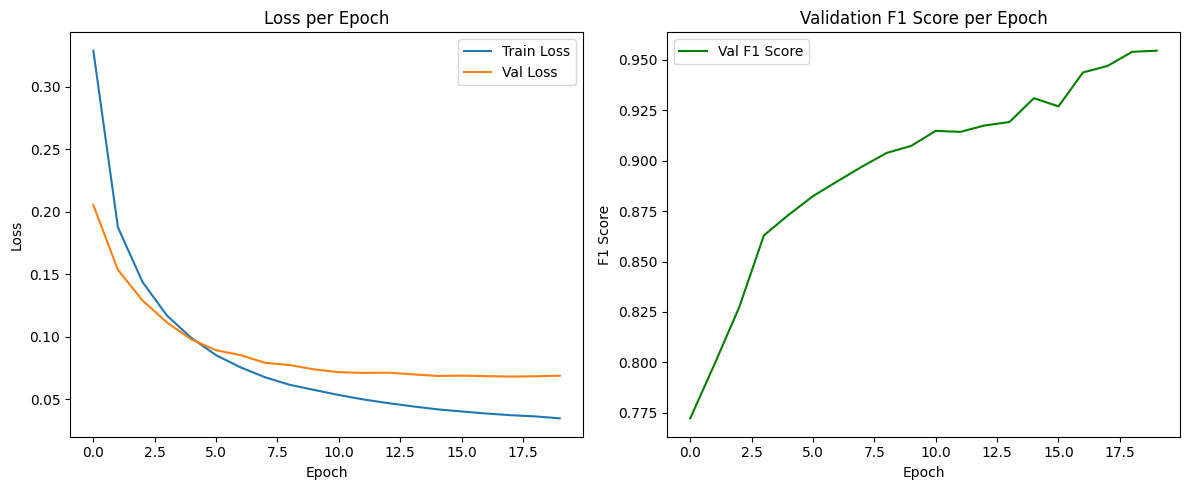

In [36]:
best_f1 = 0
patience = 2
patience_counter = 0

train_losses = []
val_losses = []
val_f1s = []

for epoch in range(20):
    model.train()
    train_loss = 0
    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch+1} - Train"):
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    all_preds, all_targets = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            val_loss += loss.item()

            preds = torch.sigmoid(logits).cpu().numpy() > 0.5
            all_preds.extend(preds)
            all_targets.extend(yb.cpu().numpy())

    val_f1 = f1_score(all_targets, all_preds, average="macro")
    train_losses.append(train_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    val_f1s.append(val_f1)

    print(f"Epoch {epoch+1} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | Val F1: {val_f1:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        patience_counter = 0
        torch.save(model.state_dict(), "best_tfidf_model.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping.")
            break

# Отрисовка графиков после завершения обучения
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_f1s, label="Val F1 Score", color='green')
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Validation F1 Score per Epoch")
plt.legend()

plt.tight_layout()
plt.show()


Качество улучшилось заметно

ниже код для предсказаний лейблов на основе модели берт.

In [ ]:
test_df = pd.read_csv("/kaggle/input/dl-2025-study-competition-2/test.csv")
test_df["cleaned_text"] = test_df["text"].apply(bert)
test_texts = test_df["cleaned_text"].tolist()
test_dataset = EventDataset(test_texts, labels=[ [0]*num_classes ]*len(test_texts), tokenizer=tokenizer)


test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
model.to(device)
all_preds = []

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs > 0.5).astype(int)
        all_preds.extend(preds)


test_df["predicted_labels"] = [" ".join(map(str, pred)) for pred in all_preds]


sample = pd.read_csv("/kaggle/input/dl-2025-study-competition-2/sample_submission.csv")
sample['labels'] = test_df["predicted_labels"]
sample.to_csv("predictions.csv", index=False)

предсказания для модели tfidf

In [ ]:
test_df = pd.read_csv("/kaggle/input/dl-2025-study-competition-2/test.csv")
test_df["cleaned_text"] = test_df["text"].apply(ti)
test_texts = test_df["cleaned_text"].tolist()


X_test = compute_tfidf_matrix(test_texts, vocab, idf)


test_dataset = torch.tensor(X_test, dtype=torch.float32)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


model = SimpleMLP(input_dim=X_test.shape[1], output_dim=number_of_classes).to(device)
model.load_state_dict(torch.load("best_tfidf_model.pt"))
model.eval()


all_preds = []
with torch.no_grad():
    for xb in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs > 0.5).astype(int)
        all_preds.extend(preds)


test_df["predicted_labels"] = [" ".join(map(str, pred)) for pred in all_preds]
sample = pd.read_csv("/kaggle/input/dl-2025-study-competition-2/sample_submission.csv")
sample["labels"] = test_df["predicted_labels"]
sample.to_csv("predictions.csv", index=False)
